# RA2CE feature: EAL - Single Link Losses analysis

    For this analysis you need 
    01. Hazard maps with return periods.The maps need to be stored in the hazard folder, have the correct naming (RP_...), be a .tif file and be in WGS84 projection

    02. Road network and traffic data file for each segement of the road network. Namely values of time/distance for each trip purpose 
    
    03.Resilience curve, a CSV file representing the function loss and the duration of the corresponding function loss.

This notebook contains an example of the **Single Link Losses analysis** of the RA2CE tool.

### Losses 

When a road section is made redundant by a hazard, the user can experience losses in two ways:  as time or as distance

This analysis first identifies the edges impacted by the hazard (water depth above a threshold). With single link redundancy analysis, the criticality for each impacted edge is calculated as vehicle loss hours. 

With single link redundancy analysis, you gain insight into the criticality of each link in the network. A redundancy analysis is performed for each separate link. It identifies the best existing alternative route if that particular edge would be disrupted. If there is no redundancy, it identifies the lack of alternative routes. This is performed sequentially, for each link of the network. 

For the impacted links with a detour, VLH is calculated using the value of time/distance, detour time/distance, function loss and its corresponding function loss. For the impacted links without detour, the principle of loss of production is applied. In short it calculated the productivity loss using the number of people commuting the impacted link without detour, productivity loss per capita per day, and the duration_event

The main outputs of this analysis will be the Vehicle Loss Hours (VLH) for the disrupted links, quantified in monetary terms (e.g., euros) for a specific part of the day (e.g., morning rush hour), categorized by each trip purpose (e.g., freight, business, etc.).

### Estimated Annual Losses

The flood risk, in terms of expected annual damage or losses (EAD or EAL) in currency per year, is calculated by integration over the damage per return frequency..

First of all, we will import the packages we need to execute the notebook:

In [1]:
import geopandas as gpd
from IPython.display import display
from pathlib import Path
import rasterio
import matplotlib.pyplot as plt
import os

Import the RA2CE Handler and Necessary RA2CE sections

In [ ]:
from ra2ce.ra2ce_handler import Ra2ceHandler # import the ra2cehandler to run ra2ce analyses

In [3]:
from ra2ce.network.network_config_data.enums.network_type_enum import NetworkTypeEnum
from ra2ce.network.network_config_data.enums.aggregate_wl_enum import AggregateWlEnum
from ra2ce.network.network_config_data.enums.source_enum import SourceEnum
from ra2ce.network.network_config_data.network_config_data import (NetworkConfigData,NetworkSection,HazardSection,)

from ra2ce.analysis.analysis_config_data.analysis_config_data import (AnalysisConfigData,ProjectSection,AnalysisSectionBase,AnalysisSectionLosses)
from ra2ce.analysis.analysis_config_data.enums.analysis_losses_enum import (AnalysisLossesEnum)
from ra2ce.analysis.analysis_config_data.enums.loss_type_enum import LossTypeEnum

from ra2ce.analysis.analysis_config_data.enums.trip_purpose_enum import TripPurposeEnum
from ra2ce.analysis.analysis_config_data.enums.weighing_enum import WeighingEnum
from ra2ce.analysis.analysis_config_data.enums.event_type_enum import EventTypeEnum
from ra2ce.analysis.analysis_config_data.enums.risk_calculation_mode_enum import RiskCalculationModeEnum
from ra2ce.analysis.analysis_config_data.enums.traffic_period_enum import TrafficPeriodEnum

from ra2ce.common.configuration.config_data_protocol import ConfigDataProtocol
from ra2ce.network.network_config_data.enums.aggregate_wl_enum import AggregateWlEnum
from ra2ce.network.network_config_data.network_config_data import (NetworkSection,OriginsDestinationsSection,HazardSection)



In [ ]:
root_dir = Path(r".\data\single_ink_losses_estimated_annual_losses")

assert root_dir.exists(), "root_dir not found."

static_path = root_dir.joinpath("static")
hazard_path =static_path.joinpath("hazard")
network_path = static_path.joinpath("network")
output_path=root_dir.joinpath("output")
input_analysis_path = root_dir.joinpath("input_analysis_data")

assert input_analysis_path.exists()

tif_files = list(hazard_path.glob("*.tif"))

tif_file_names = [file.name for file in tif_files]
tif_file_names

## Visualizing the Hazardmap

In [ ]:
# Loop through each tif file and plot it
for tif_file in tif_files:
    with rasterio.open(tif_file) as src:
        tif_array = src.read(1)  # Read the first band
        crs = src.crs  # Get the Coordinate Reference System

    print(f"File: {tif_file.name}, CRS: {crs}")
    
    plt.figure(figsize=(10, 10))
    plt.imshow(tif_array, cmap='Blues')
    plt.colorbar(label='Pixel Values')
    plt.title(f'Hazard map: {tif_file.name}\nCRS: {crs}')
    plt.show()

## Next lets create input data for losses analysis

On top of the network and the hazard map, the losses analysis requires 3 additional CSV files:
   - Traffic intensity (number of vehicles) 
   - Values of time/distance
   - Resilience curve (i.e. function loss and the duration of the corresponding function loss)

The csv file are then places in the ```_input_analysis_path``` directory:

### Create traffic intensities table

As a user, it is your responsibility to provide the traffic intensity for all the links in the network in a table. The first column must have the same name as the corresponding column name in the network shapefile to link corresponding edge ID.

The traffic intensity can be differentiated between classes of trips. You have to chooses among the pre-defined classes (BUSINESS, COMMUTE, FREIGHT, OTHER) and use the following structure for column names : ```day_typeoftrip``` or ```evening_typeoftrip```.

The traffic intensity should be expressed in number of vehicle per day.

    Fill a csv table with the traffic intensity

| ID  | evening_commute | evening_freight | evening_total | day_commute | day_freight | day_total |
|-----|-----------------|-----------------|---------------|-------------|-------------|-----------|
| 1   |     0   |   0     |  0     | 100   | 200    | 300   |
| 2   |    0  |     0  |    0  |  50 | 20   | 70  |
| 3   |    10    | 2      |  12     |   30  | 32   | 62 |



### Create values of time

As a user, you also need to specify the value of time for every class of trip defined in the traffic intensity. It represents the amount of money lost per unit of time due to unavailability of a disrupted link.

The value of time can be either expressed per hour of delay or per km of detour. The unit of currency also depends on the value entered in this table.
The average number of occupants per vehicle is also required for each class of trip. This value is need to compute the losses for links without alternative routes.

| trip_types | value_of_time | occupants |
|------------|---------------|-----------|
| commute    | 10      | 1       |
| freight     | 20     | 2         |

In this example table, cars from the commute class experience a loss of 10$ per hour of disruption.

### Create Resilience curves

The last required input file corresponds to the definition of the resilience curves for the different road types of the network. Each road type (highway, residential, ...) are affected and recover differently for a given hazard level. This are defined here:

The column ```link_type_hazard_intensity``` controls which resilience curve to be picked for every road type and level of hazard. The hazard intensity has the same unit as the one defined in the hazard map (and overlaid network). For example for ```highway_0-0.5```, the corresponding resilience curve will be used for all links of type highway with a hazard level (think water depth for example) between 0 and 0.5. The table should be comprehensive enough to cover all road types and for every encountered hazard level.

The resilience curves are defined with duration steps (in hours) and loss of functionality between 0 and 1. In the example table below for the first row:
- at t=0, the link is 100% functional
- between t=0 and t=10h, the link is 50% functional
- between t=10h and t=10+30=40h, the link is 70% functional
- between t=40h and t=10+30+50=90h, the link is 90% functional
- after t>90h, the link is 100% functional again.

| link_type_hazard_intensity | duration_steps | functionality_loss_ratio |
|----------------------------|----------------|--------------------------|
| highway_0-0.5                | [10.0, 30.0, 50.0]       |   [0.5, 0.3, 0.1]               |
| highway_0.5-2                 | [10.0, 40.0, 100.0]     | [0.75, 0.5, 0.25]               |
| residential_0-2                   | [5, 10, 15] | [0.75, 0.5, 0.25]                  |

## Now we will set the parameters that are required to run this RA2CE analysis

    BE AWARE THAT THE FLOOD MAPS HAVE A SPECIFIC NAME FORMAT. IF YOU DO NOT USE THE CORRECT FORMAT, RA2CE WILL NOT BE ABLE TO EXECUTE THE RETURN PERIOD ANALYSIS. 
    
    The hazard files should have *RP_<return_period>* phrase in it, where *<return_period>* refers to the return period in years

There are three different methods of calculating the expected annual risk of lossess as a result of the hazard. Below we schematize the different concepts briefly. There is more explanation available in the online RA2CE documentation. The expected annual losses can be calculated in three different ways. 

Note that the 'original data points' refer to the hazard's return period. These return periods stem from the hazard maps that are introduced by the user. The more return periods we have, the easier it is to 'interpolate' the curve and the more accurate the expected annual loss will be. 

1. **Default mode** in this mode, we take the area under the curve up until the highest provided return period. We do not consider risks beyond the highest provided return period, so that we do not introduce errors as a result of assumptions there. This means that there will be no loss for all events with a return period smaller than the smallest known Return Period. This method also does not account for any flood protection in place. 

2. **Cut from mode** in this mode, we can set a cut-off value (risk_calculation_year). We assume that if the return period is smaller than the cut-off value, it does not contribute to the risk. You can use such an assumption for example when there is flood protection in place, or if you want to know what the residual risk would be if you would put flood protection up to a certain return period and determine to which return period you would want to protect your infrastructure from losses. 

3. **Triangle to null mode** in this mode, we make an estimation of the total risk, including the risk for smaller return periods than the lowest return period provided in the hazard map introduced by the user. From the lowest known return period, we linearly extrapolate the losses to at which return period they would be zero. If you use this method, you can specify the RP for which losses are zero, by specifying the (risk_calculation_year) parameter in combination with the triangle to null mode. This method does not account for flood risk protection. This method is adviced if you do not have smaller return period maps, so that at least you account for some of the losses that occur in more regular floods. 



In all the modes we assume that the loss corresponding to the highest known return period is the highest loss that can occur. 

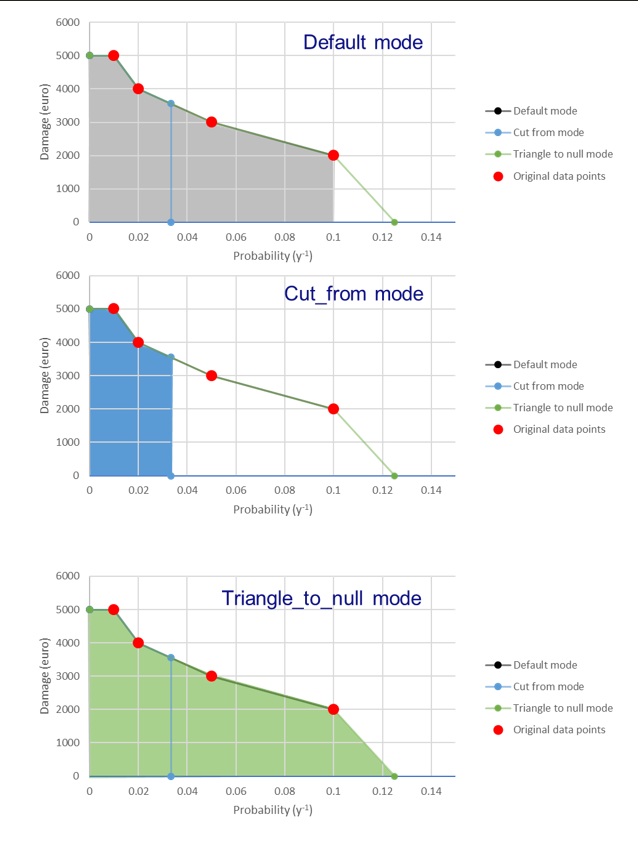

In [6]:
network_section = NetworkSection(
    directed=False,                     #Used together with OSM download - False if you want to have an undirected graph and True if you want to have a directed graph. 
    source= SourceEnum.SHAPEFILE,       #Used to specify the shapefile name of the (road) network to do the analysis with, when creating a network from a shapefile.*only this is supported
    primary_file = [root_dir/"static"/"network"/"network.shp"], #soecify in the RA2CE folder setup where the network is locates
    diversion_file= None,
    file_id = "ID", #should be the same as the traffic intensity file link id column name
    link_type_column='highway',
    polygon= None,
    network_type=NetworkTypeEnum.NONE,
    road_types=None,
    save_gpkg=True,
    ) 

hazard_section = HazardSection(
    hazard_map= [Path(file) for file in hazard_path.glob("*.tif")],
    aggregate_wl = AggregateWlEnum.MEAN, 
    hazard_crs = "EPSG:32736",  #The crs of your flood maps
)
   
#pass the specified sections as arguments for configuration
network_config_data = NetworkConfigData(
    root_path= root_dir,
    output_path= output_path,
    network=network_section,
    hazard=hazard_section,
    static_path=static_path,
    )


In [7]:
losses_analysis = [AnalysisSectionLosses( 
  name = 'Single_link_losses',  #specify the name for your analysis
  analysis= AnalysisLossesEnum.SINGLE_LINK_LOSSES, #If you do losses analysis you should choose losses here. Could be MULTI_LINK_LOSSES or SINGLE_LINK_LOSSES. We are doing SINGLE_LINK_LOSSES in this example
  event_type = EventTypeEnum.RETURN_PERIOD, #We can specify return period based and event based here. If you have multiple flood maps with return periods, put return period.
  risk_calculation_mode = RiskCalculationModeEnum.CUT_FROM_YEAR,  # default, cut_from_year, or triangle_to_null_year
  risk_calculation_year = 200,      #For Triangle_to_null_year: this parameters is the year at which the damages are assumed to be zero. You can only put a number below your lowest RP.
                                    #For cut_from_mode: this parameter is the year below which we assume no damage (usually because of protection or adaptation measures). For this mode you need to specify a number above your lowest provided RP. 
                                    #For the default mode this parameter is not used
  weighing = WeighingEnum.TIME,    #time or length
  threshold = 0.0,  #the water height threshold above which the link will be inundated
  production_loss_per_capita_per_hour =12, 
  traffic_period= TrafficPeriodEnum.DAY,  #The temporal resolution of the traffic intensity file
  trip_purposes= [TripPurposeEnum.BUSINESS,TripPurposeEnum.COMMUTE,TripPurposeEnum.FREIGHT,TripPurposeEnum.OTHER],

  #the path for csv files you made for resilience curve, traffic intensities and value of time should be specified here
  resilience_curves_file= input_analysis_path.joinpath("resilience_curve.csv"),
  traffic_intensities_file= input_analysis_path.joinpath("traffic_intensities.csv"),
  values_of_time_file= input_analysis_path.joinpath("values_of_time.csv"),

  #save your outputs as both csv and gpkg in the output folder
  save_csv=True,
  save_gpkg=True
  )]

analysis_config_data = AnalysisConfigData(
    analyses= losses_analysis,
    root_path= root_dir,
    output_path= output_path,
    )


### Running RA2CE
We configure and run the single link redundancy analysis with the following methods from the Ra2ceHandler class. We do not have to introduce a new network as we use the existing graph that we created before.<br>

*Note: when there is an existing base_graph in the output_graph folder, RA2CE will always use this. However, it can be that you want to update something to that base_graph. In that case, you first have to remove the graph from the folder manually before rerunning.* 

In [ ]:
handler = Ra2ceHandler.from_config(network_config_data, analysis_config_data)

handler.configure()
handler.run_analysis()

## Inspecting results
Done. Let's inspect the results!

In [ ]:
Losses_gdf = gpd.read_file(output_path/ "single_link_losses" /"Single_link_losses.gpkg") #specify the name of the geopackage holding your results (can be found in the analysis output folder)
Losses_gdf.head()

As you can see in the above cell,The output will include Vehicle Loss Hours (VLH) of the disrupted links in a currency (e.g., €) for a given part of the day (e.g., morning rush hour) for each trip purpose (e.g., freight, business, etc.)<br> 
The output type is gpkg, with generated columns in the result file such as vlh_<trip purpose>_<EVi>_<method> or vlh_<trip purpose>_<RPj>_<method> and vlh_total_<EVi>_<method> or vlh_total_<RPj>_<method> (if event-based or return-period based analyses respectively). EV stands for event and RP stands for return period). The vlh_total column sums all vlh_<trip purpose> columns. 

<br>An example is vlh_business_EV1_ma, where EVi refers to each flood map (introduced as events without return periods) introduced in the network.ini or the configuration, and method refers to min, mean, max water level aggregation method.

<br>The column risk_vlh_total represents the risk or estimated annual losses of the included hazards (with return periods) based on the risk calculation method you chose in the _losses_analysis section

Lets visualize the estimated annual losses of the included hazards

### Explore Estimated Annual Losses

In [ ]:
Losses_gdf['Total Loss'] = Losses_gdf['risk_vlh_total']
Losses_roads_map = Losses_gdf.explore(column='Total Loss', tiles="CartoDB positron", cmap='winter_r')
display(Losses_roads_map)

What is the total risk to the network according to this method?
<br>Keep in mind that , during the analysis we put a risk calculation year and our risk calculation method as TRIANGLE_TO_NULL_YEAR. Therefore the damages are extrapolated to 0 from risk calculation year flood map

In [ ]:
total_risk = Losses_gdf["risk_vlh_total"].sum()
valuta = "vlh"

print(f"Total risk from this hazard on the analyzed road network according to the specified method is: {round(total_risk, 0)} {valuta}")

### Explore losses in the network

In addition, the outputs further contain the information loss calculations per each flood map and their respective trip purpose. We can also explore these here.

Lets explore total losses for each flood map in our hazard folder

In [ ]:
return_period = 'RP1000' #Specify the return period : options for this example RP1000, RP100, RP10
Losses_gdf.explore(column=f'vlh_{return_period}_me_total', tiles="CartoDB positron", cmap='winter_r')

In [ ]:
total_loss_per_RP = Losses_gdf[f'vlh_{return_period}_me_total'].sum()
valuta = "vlh"

print(f"Total loss from this hazard on the analyzed road network for the loof map with retur period {return_period} is: {total_loss_per_RP} {valuta}")

We can also explore losses for different trip_purposes different for hazard maps in our hazard folder

In [ ]:
return_period = 'RP1000' #Specify the return period : options for this example RP1000, RP100, RP10
trip_purpose = 'freight' #Specify the trip purpose

Losses_gdf.explore(column=f'vlh_{trip_purpose}_{return_period}_me', tiles="CartoDB positron", cmap='winter_r')

In [ ]:
total_loss_per_RP = Losses_gdf[f'vlh_{trip_purpose}_{return_period}_me'].sum()
valuta = "vlh"

print(f"Total loss from this hazard on the analyzed road network for the flood map with return period {return_period} for trip purpose {trip_purpose} is: {round(total_loss_per_RP, 0)} {valuta}")